In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

2024-04-22 13:20:37.510992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import time

# Record start time
start_time = time.time()

## Neural Network on PCA Results

In [3]:
# Directory where PCA results are saved
pca_dir = "../../data/pca_data/byBasin_pca"
result_dir = "../../data/performance_comparison"

# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withPCA"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Get a list of all PCA result files
pca_files = [f for f in os.listdir(pca_dir) if f.endswith('_pca_with_target.csv')]

# Dictionary to store results for each basin
results = {}

# Process each PCA result file
for file in pca_files:
    basin_name = file.replace('_pca_with_target.csv', '').replace(' ', '_')  # Replace spaces with underscores
    sanitized_basin_name = basin_name.replace(' ', '_')  # Sanitize basin name for file paths
    pca_df = pd.read_csv(f"{pca_dir}/{file}")

    # Separate data with known and unknown 'Li' values
    known_data = pca_df.dropna(subset=['Li'])
    unknown_data = pca_df[pca_df['Li'].isnull()]

    # Prepare training and testing data from known data
    principal_components = [f'PC{i+1}' for i in range(10)]  # Use the first 10 principal components
    X_known = known_data[principal_components]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Calculate the percentage of predictions within certain percentage ranges
    target_percentage = 15
    threshold_15 = (target_percentage / 100) * np.mean(y_test)
    within_15 = np.mean(np.abs(y_test - y_pred) <= threshold_15) * 100

    # Store results for known data evaluation
    results[basin_name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Explained Variance': explained_variance, "Percent of Predicted\nWithin 15 Percent of Actual": within_15}
    print(f"Basin: {sanitized_basin_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect prediction
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {sanitized_basin_name}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin_name}_actual_predicted_neural_network_pca.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[principal_components]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred

        pca_df.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Save predicted data for unknown values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin_name}_predicted_Li_neural_network_pca.csv")
        pca_df.to_csv(predicted_data_path, index=False)

        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {sanitized_basin_name}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin_name}_neural_network_predicted_distribution.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_with_pca = pd.DataFrame(results).T
nn_results_df_with_pca.to_csv(os.path.join(result_dir, "neural_network_performance_PCA.csv"), index_label='Basin')

print("Saved performance metrics with PCA to CSV.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Basin: Rocky_Mountain - MSE: 43.59502963725514, R2: 0.7967755347830416, MAE: 3.538620467468989, RMSE: 6.602653227094025, Explained Variance: 0.7967891983011988
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Basin: Fort_Worth - MSE: 91.06264749233259, R2: 0.9256955977310134, MAE: 5.139543704986572, RMSE: 9.542675070038412, Explained Variance: 0.9452013396062888
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Basin: Illinois - MSE: 80.76089043060378, R2: 0.5776103703512665, MAE: 6.489764152526855, RMSE: 8.98670631714444, Explained Variance: 0.5827615068203764
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Gulf_Coast - MSE: 887.3355242322651, R2: 0.8431251527056648, MAE: 15.792263705575632, RMSE: 29.788177591659835, Explained Variance: 0.8488546318438015
427/427 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Basin: Michigan - 

### Neural Network on Imputed Data without PCA

In [4]:
# Load the dataset with all basins
df = pd.read_csv("../../data/df_output/df_cleaned_imputed.csv")


# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withoutPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withoutPCA"
result_dir="../../data/performance_comparison"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Define features to use for predicting 'Li'
predictors = ['B', 'Ba', 'Br', 'HCO3', 'FeTot', 'K', 'Na', 'Cl', 'SO4', 'Mg', 'Ca', 'Sr', 'Zn', 'TDS', 'DEPTHUPPER']

# Dictionary to store results for each basin
results = {}

# Loop through each unique basin category
for basin in df['BASIN_CATEGORY'].unique():
    sanitized_basin = basin.replace(' ', '_')  # Replace spaces with underscores
    print(f"Processing Gradient Boosting for {basin}")
    df_basin = df[df['BASIN_CATEGORY'] == basin]

    # Separate data with known and unknown 'Li' values
    known_data = df_basin.dropna(subset=['Li'])
    unknown_data = df_basin[df_basin['Li'].isnull()]

    # Prepare training and testing data from known data
    X_known = known_data[predictors]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Calculate the percentage of predictions within certain percentage ranges
    target_percentage = 15
    threshold_15 = (target_percentage / 100) * np.mean(y_test)
    within_15 = np.mean(np.abs(y_test - y_pred) <= threshold_15) * 100

    # Store results for known data evaluation
    results[basin] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Explained Variance': explained_variance,
        "Percent of Predicted\nWithin 15 Percent of Actual": within_15
    }
    print(f"Basin: {basin} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {basin}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin}_actual_predicted_neural_network_no_pca.png")
    plt.savefig(plot_path)
    plt.close()


    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[predictors]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred

        # Merge the predictions back to the main DataFrame
        df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Optional: to also show original 'Li' in the same column where available
        df_basin.loc[known_data.index, 'Predicted_Li'] = known_data['Li']

        # Save the full basin DataFrame including both known 'Li' and predicted 'Li' values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin}_predicted_Li_neural_network_no_pca.csv")
        df_basin.to_csv(predicted_data_path, index=False)


        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {basin}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin}_predicted_distribution_neural_network_no_pca.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_without_pca = pd.DataFrame(results).T
nn_results_df_without_pca.to_csv(os.path.join(result_dir, "neural_network_performance_no_pca.csv"), index_label='Basin')

print("Saved performance metrics without PCA to CSV.")

Processing Gradient Boosting for Appalachian
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Basin: Appalachian - MSE: 121064.7570669736, R2: -32.13549858274264, MAE: 300.6895908574112, RMSE: 347.9436119071215, Explained Variance: -7.767057524626267
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Processing Gradient Boosting for Permian
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Basin: Permian - MSE: 5556.275735986307, R2: -0.09264260608307495, MAE: 39.85948602575616, RMSE: 74.54043021063339, Explained Variance: 0.09264495192499878
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing Gradient Boosting for Oklahoma Platform
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Basin: Oklahoma Platform - MSE: 5845485.456280058, R2: -18607.642372732123, MAE: 446.3304568840476, RMSE: 2417.7438773120816, Explained Variance: -18138.62164782609
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing Gradient Boosting for Gulf Coast
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Basin: Gulf Coast - MSE: 38620.87635559236, R2: -5.82790659812586, 

## Performance Comparison

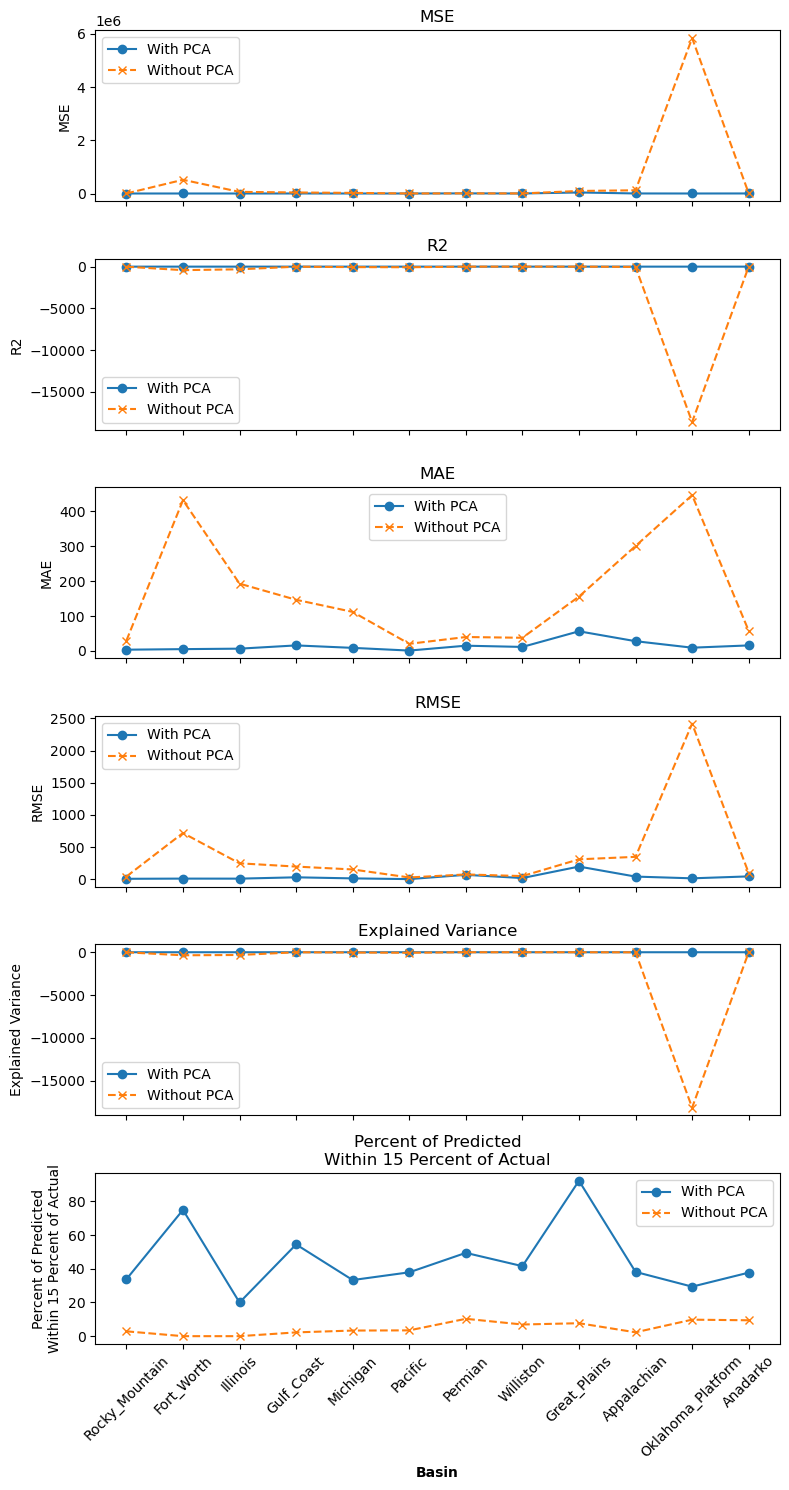

In [5]:
# Load results DataFrames
nn_results_df_with_pca = pd.read_csv("../../data/performance_comparison/neural_network_performance_pca.csv")
nn_results_df_without_pca = pd.read_csv("../../data/performance_comparison/neural_network_performance_no_pca.csv")

# Replace spaces with underscores in the basin names
nn_results_df_with_pca['Basin'] = nn_results_df_with_pca ['Basin'].str.replace(' ', '_')
nn_results_df_without_pca['Basin'] = nn_results_df_without_pca['Basin'].str.replace(' ', '_')

# Set 'Basin' as index now that the names are sanitized
nn_results_df_with_pca .set_index('Basin', inplace=True)
nn_results_df_without_pca.set_index('Basin', inplace=True)

# Merge the two results DataFrames
nn_combined_results = nn_results_df_with_pca.join(nn_results_df_without_pca, lsuffix='_with_pca', rsuffix='_without_pca')

# Define the metrics to compare
metrics = ['MSE', 'R2', 'MAE', 'RMSE', 'Explained Variance', "Percent of Predicted\nWithin 15 Percent of Actual"]

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 15), sharex=True) # previously [10, 20]

# Plot comparisons for each metric
for idx, metric in enumerate(metrics):
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_with_pca'], marker='o', label='With PCA', linestyle='-')
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_without_pca'], marker='x', label='Without PCA', linestyle='--')
    
    axs[idx].set_ylabel(metric)
    axs[idx].set_title(metric)
    axs[idx].legend()

# Set common labels
plt.xlabel('Basin', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.savefig("../../images/performance_comparison_plots/neural_network_performance_comparison.png")

In [6]:
# Record end time
end_time = time.time()

# Calculate total run time
total_time = end_time - start_time

print(f"Total run time: {total_time} seconds | {total_time/60} minutes")

Total run time: 593.9099218845367 seconds | 9.898498698075612 minutes
